# Universe Machine mass functions

* SMF of the new UM when considering in-situ, ex-situ, and the sum of both compared to Songs SMF
* look at the scatter in M* and Mhalo
- for in-situ
- for in-situ + ex-situ
- for N most massive galaxies

TODO:
* finalize setup code (see song's comments)
* work out why we don't see much reduction in scatter
* plot SMF using song's helpers (https://redwoodforest.slack.com/files/U5WQ5K6BV/F8D28UNQY/simple_functions_to_estimate_stellar_mass_function.py)
    * Talk to song about potential bug in calculating errors here
    * question about https://github.com/dr-guangtou/hsc_um2/blob/master/hsc_um2/stellar_mass_function.py#L44-L50. We are computing the error on the normalized smf and then normalizing the error again. I think this would be right if the SMF norm step came after this if block? We should compute Poisson errors on the unscaled SMF counts?
* Add labels to plotly figures

## Install and load data

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Local libs
import plots
import cluster_sum
import stellar_mass_function as smf
from importlib import reload # for when I mess up local libs

In [2]:
datadir = os.getenv("dataDir") + "/universe_machine/"
catalog_file = "sfr_catalog_insitu_exsitu_0.712400_final.npz"

catalog = np.load(datadir + catalog_file)
centrals = catalog["centrals"]
satellites = catalog["satellites"]

# Our data

Let's get a very broad sense of our data

In [4]:
print(centrals.dtype)
print(len(centrals))
print(len(satellites))
print(satellites[:10])

[('id', '<i8'), ('upid', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('mp', '<f8'), ('sm', '<f8'), ('icl', '<f8'), ('sfr', '<f8')]
385125
10809469
[ (8272347655, 8272347654,  13.83487,  18.749399,  16.14661 ,   1.98400000e+09,   3.11700000e+09,   2.31400000e+05,   0.00000000e+00,   6.41000000e-05)
 (8272348262, 8272347732,  15.026  ,  17.7521  ,  17.388531,   1.98400000e+09,   2.26700000e+09,   1.15200000e+03,   0.00000000e+00,   2.51000000e-06)
 (8272348449, 8272347732,  15.09965,  17.864719,  17.39245 ,   4.10900000e+09,   9.77600000e+09,   3.21900000e+05,   0.00000000e+00,   1.55000000e-04)
 (8272347739, 8272347732,  15.12861,  17.99032 ,  17.20083 ,   2.40900000e+09,   4.67600000e+09,   5.25000000e+05,   0.00000000e+00,   9.07200000e-05)
 (8272346869, 8272347732,  14.98359,  18.042549,  17.36433 ,   2.97500000e+09,   5.24200000e+09,   2.55700000e+06,   0.00000000e+00,   3.47100000e-04)
 (8272361474, 8272347732,  15.10398,  17.784781,  17.37109 ,   1.21800000e+10

385117 centrals without ICL of our 385125 samples


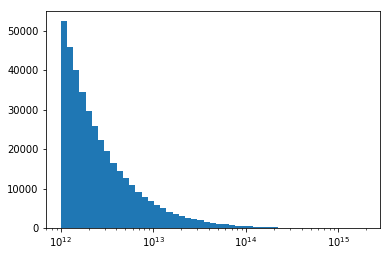

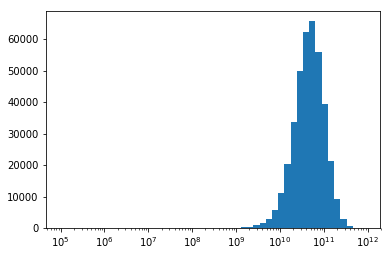

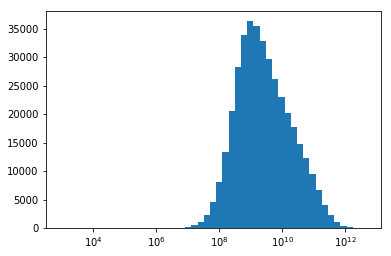

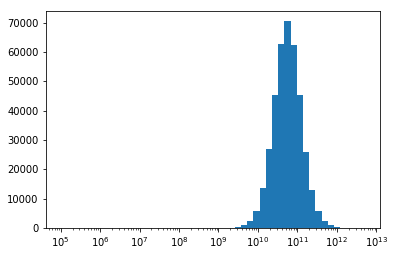

In [5]:
fig, ax = plt.subplots()
_ = ax.hist(centrals["mp"], bins = np.geomspace(np.amin(centrals["mp"]), np.amax(centrals["mp"]), 50))
_ = ax.set(xscale="log")

fig, ax = plt.subplots()
_ = ax.hist(centrals["sm"], bins = np.geomspace(np.amin(centrals["sm"]), np.amax(centrals["sm"]), 50))
_ = ax.set(xscale="log")

fcentrals = centrals[np.nonzero(centrals["icl"])[0]]
fig, ax = plt.subplots()
_ = ax.hist(fcentrals["icl"], bins = np.geomspace(np.amin(fcentrals["icl"]), np.amax(fcentrals["icl"]), 50))
_ = ax.set(xscale="log")
print(
    "{} centrals without ICL of our {} samples".format(len(np.nonzero(centrals["icl"])[0]), len(centrals))
)

fig, ax = plt.subplots()
_ = ax.hist(
    centrals["icl"] + centrals["sm"],
    bins = np.geomspace(
        np.amin(centrals["icl"]) + np.amin(centrals["sm"]),
        np.amax(centrals["icl"]) + np.amax(centrals["sm"]),
        50))
_ = ax.set(xscale="log")

# SMHM relations

Now let's plot the SM, halo mass relations for centrals

[ 0.29092294  0.31359733  0.34762706  0.37444957  0.39354997  0.40302164
  0.410525    0.40941705  0.40289989  0.38817751  0.37117776  0.40097804
  0.50963308  0.4503301   0.26000494  0.17407276]
[ 0.57558655  0.59859665  0.60259917  0.5768167   0.53822684  0.48914086
  0.43249393  0.37680132  0.33603209  0.30391911  0.26811161  0.24549148
  0.24935111  0.19430724  0.20073654  0.18747049]
[ 0.28336689  0.29449404  0.30661395  0.30780795  0.30062035  0.29121707
  0.2762067   0.25854637  0.24371529  0.22672315  0.21668335  0.21625001
  0.22194107  0.17394179  0.18812695  0.17680674]


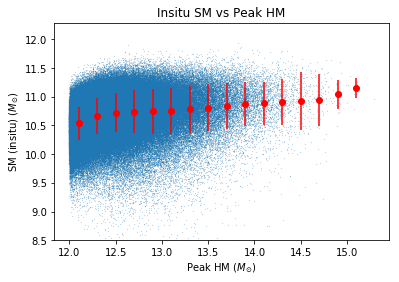

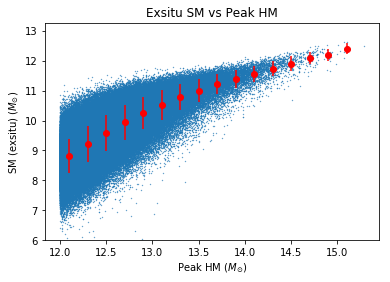

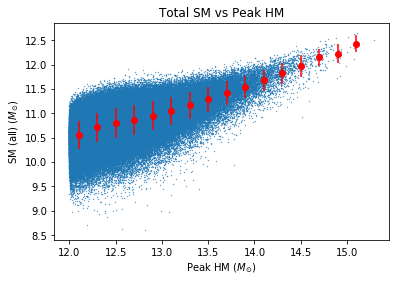

In [6]:
reload(plots)
ax = plots.dm_vs_insitu(centrals)
ax.set(ylim=8.5) # ignore crazy small galaxies

ax = plots.dm_vs_exsitu(centrals)
ax.set(ylim=6) # not sure why by default it ignores a bunch of data

plots.dm_vs_all_sm(centrals)

# SMHM for cluster

What happens if we start to plot this relation for multiple members of the cluster?

In [13]:
reload(cluster_sum)
data = np.array(
    [centrals] + 
    [cluster_sum.centrals_with_satellites(centrals, satellites, i) for i in range(1, 10)]
)

In [14]:
allSats = cluster_sum.centrals_with_satellites(centrals, satellites, 0.999)

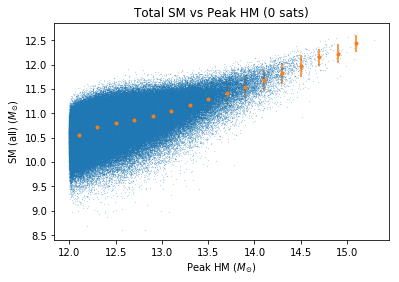

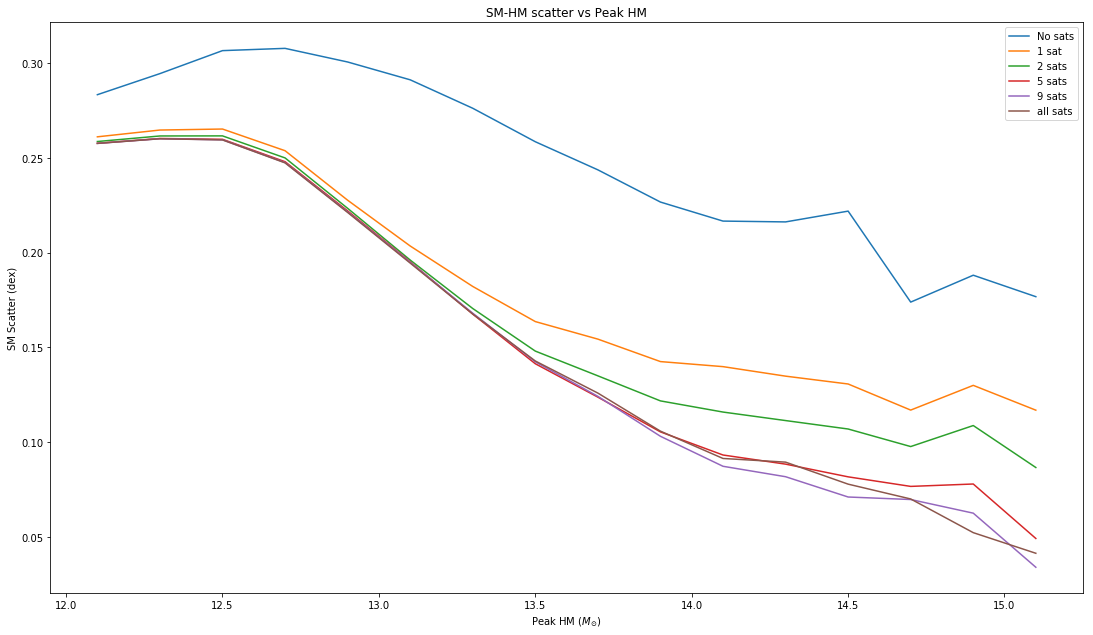

In [40]:
reload(plots)
for f in [plots.dm_vs_all_sm]:
    ax = f(data[0])
    ax.set_title(ax.get_title() + " (0 sats)")
    """
    ax = f(data[2])
    ax.set_title(ax.get_title() + " (2 sats)")

    ax = f(allSats)
    ax.set_title(ax.get_title() + " (all sats)")
    """
plots.dm_vs_all_sm_error([data[0], data[1], data[2], data[5], data[9], allSats], 
                           labels = ["No sats", "1 sat", "2 sats", "5 sats", "9 sats", "all sats"])

# Plotly

Let's see if we can make some interactive plots that illustrate this better

In [75]:
# Downsample to ~ 1000 random points
np.random.seed(2) # reproducibility
mask = np.unique(np.random.randint(0, fullData.shape[1], 1000))
pData = np.append(data[:,mask], [allSats[mask]], axis = 0)

In [76]:
pData.shape

(11, 998)

In [77]:
reload(plots)
fig = plots.plotly_stuff(pData, y_cols = ["icl", "sm"])
py.iplot(fig, filename='basic-scatter')

# SMF

What does our SMF look like?

[    12    129   2193  23591 113212 167403  67712   9886    925     62]
[   3.46410162   11.35781669   46.8294779   153.59361966  336.4699095
  409.14911707  260.21529548   99.42836617   30.41381265    7.87400787]
[  8.80161096   9.20713809   9.61266523  10.01819237  10.42371951
  10.82924664  11.23477378  11.64030092  12.04582805  12.45135519] [  2.95911146e-02   3.18104482e-01   5.40777620e+00   5.81736654e+01
   2.79172439e+02   4.12803447e+02   1.66972796e+02   2.43781466e+01
   2.28098175e+00   1.52887426e-01] [ 0.00854222  0.02800754  0.11547804  0.37875053  0.82970997  1.00893153
  0.64167172  0.24518301  0.07499822  0.01941672]


(0, 0.1)

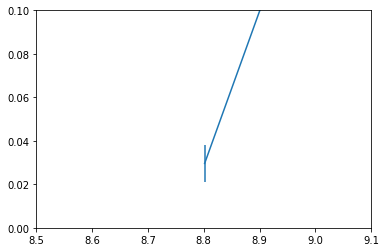

In [95]:
reload(smf)
# for insitu stellar mass
total_central_masses = np.log10(data[0]["sm"] + data[0]["icl"])
# N.B. this 1000 as volume is a guess based of MDPL2. This might change. But just changes scaling not shape
x, y, err = smf.compute_smf(
    total_central_masses, 1000, 10,
    np.min(total_central_masses), np.max(total_central_masses),
)
print(x, y, err)
fig, ax = plt.subplots()
ax.errorbar(x, y, yerr = err)